<a href="https://colab.research.google.com/github/yckamra/MNIST_Digit_Recognizer/blob/main/MNIST_Pytorch_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Found from an online resource. This allows us to graph our images
def plot_matrix_grid(V):
    k, m, n = V.shape
    ncol = 8                                     # At most 8 columns
    nrow = min(4, (k + ncol - 1) // ncol)        # At most 4 rows
    V = V[:nrow*ncol]                            # Focus on just the matrices we'll actually plot
    figsize = (2*ncol, max(1, 2*nrow*(m/n)))     # Guess a good figure shape based on ncol, nrow
    fig, axes = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=figsize)
    vmin, vmax = np.percentile(V, [0.1, 99.9])   # Show the main range of values, between 0.1%-99.9%
    for v, ax in zip(V, axes.flat):
        img = ax.matshow(v, vmin=vmin, vmax=vmax, cmap=plt.get_cmap('gray'))
        ax.set_xticks([])
        ax.set_yticks([])
    fig.colorbar(img, cax=fig.add_axes([0.92, 0.25, 0.01, .5]))   # Add a colorbar on the right

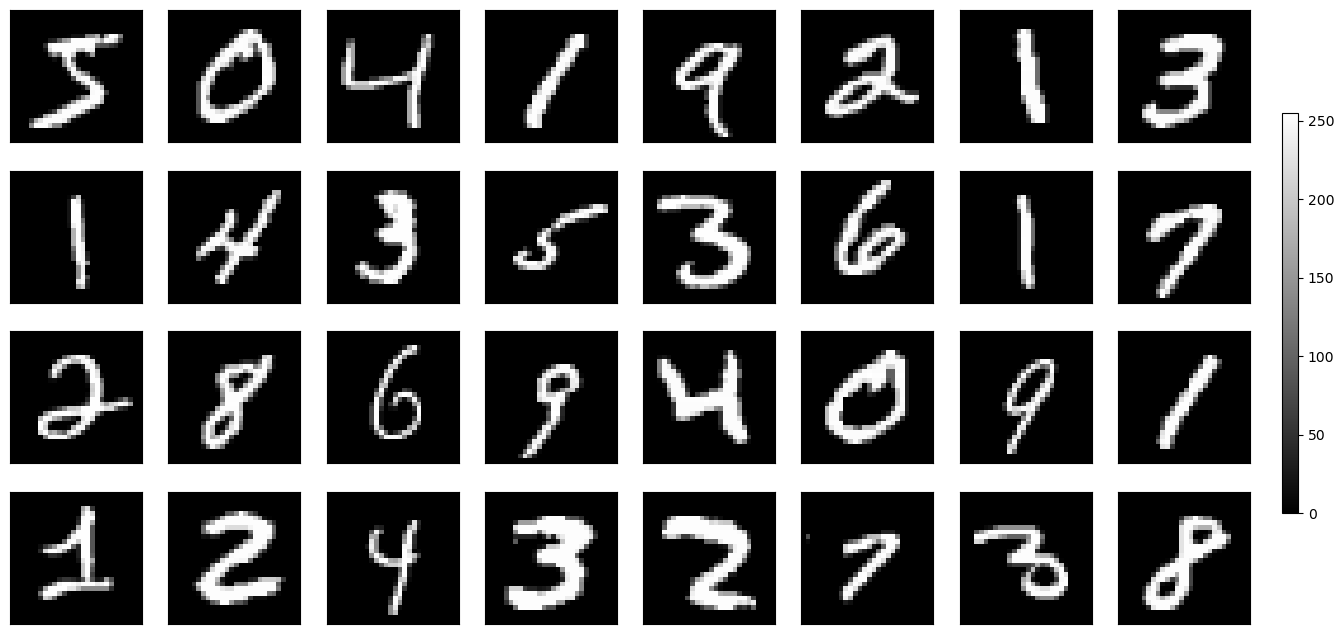

In [ ]:
with np.load("mnist_train.npz") as data:
    X_trn = data['X']
    y_trn = data['y']
with np.load("mnist_test.npz") as data:
    X_tst = data['X']
    y_tst = data['y']

X_trn = X_trn.reshape(-1, 28, 28)
X_tst = X_tst.reshape(-1, 28, 28)

plot_matrix_grid(X_trn.reshape(-1, 28, 28))

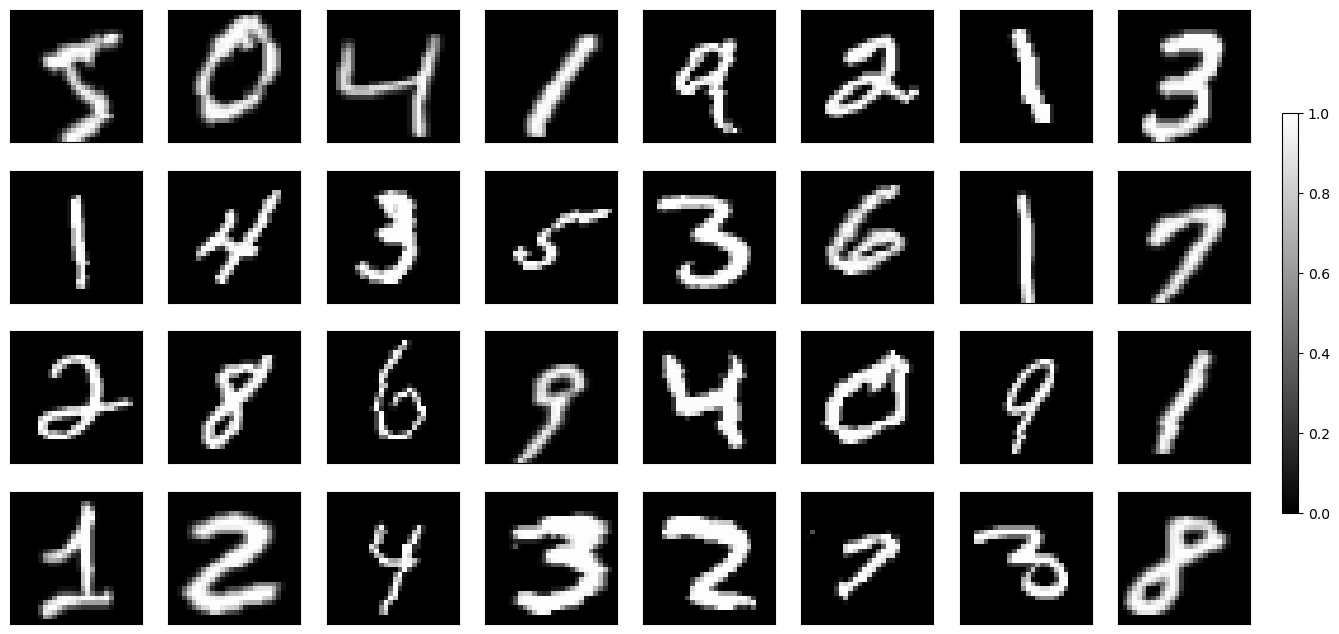

In [ ]:
# Augmentations setup
augmentations = transforms.Compose([
    transforms.RandomRotation(degrees=10),      # Rotate by a random angle with restriction of 15
    transforms.RandomResizedCrop(28, scale=(0.8, 2.5)),  # Randomly scale and crop, but keep the size 28x28
    transforms.ToTensor(),                      # Turn into tensor
    transforms.Lambda(lambda x: x.view(-1)) # Flatten the image to 1D array (28x28 to 784)
])

transform = transforms.Compose([
    transforms.ToTensor(), # Turn into tensor and will normalize pixel_value / 255
    transforms.Lambda(lambda x: x.view(-1)) # Flatten the image to 1D array (28x28 to 784)
])

X_trn_torch = torch.stack([augmentations(Image.fromarray(X_trn[i])) for i in range(X_trn.shape[0])])
X_tst_torch = torch.stack([transform(Image.fromarray(X_tst[i])) for i in range(X_tst.shape[0])])

y_trn_torch = torch.tensor(y_trn, dtype=torch.int64)
y_tst_torch = torch.tensor(y_tst, dtype=torch.int64)

plot_matrix_grid(X_trn_torch.reshape(-1, 28, 28))

In [ ]:
torch.manual_seed(0) # Let's keep it consistent

model = torch.nn.Sequential(
    torch.nn.Linear(in_features=784, out_features=128),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=128, out_features=64),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=64, out_features=10),
    torch.nn.Softmax(dim=1)
)

In [ ]:
# Hyperparameters
num_epoch = 10
learning_rate = 0.1
next_epoch = 1
batch_size = 128

# Optimizer and loss
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
def get_accuracy(model, X, y):

    model.eval()

    with torch.no_grad():
        predictions = model(X)

    probabilities = torch.softmax(predictions, dim=1)

    pred = torch.argmax(probabilities, dim=1)

    correct = (pred == y).sum().item()

    accuracy = correct / y.size(0)

    return accuracy

accuracy_list_train = []
accuracy_list_test = []

for epoch in range(next_epoch, next_epoch+num_epoch):

    for i in range(0, len(X_trn), batch_size):

        model.train()
        optimizer.zero_grad()

        X = X_trn_torch[i:i+batch_size]
        y = y_trn_torch[i:i+batch_size]

        y_pred = model(X)
        l = loss(y_pred, y)

        model.zero_grad()
        l.backward()
        optimizer.step()

    print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))

    accuracy_list_train.append(get_accuracy(model, X_trn_torch, y_trn_torch))

    accuracy_list_test.append(get_accuracy(model, X_tst_torch, y_tst_torch))

print("Epoch %2d: loss on test set: %.4f" % (epoch, loss(model(X_tst_torch), y_tst_torch)))
next_epoch = epoch+1

Epoch  1: loss on final training batch: 1.7908
Epoch  2: loss on final training batch: 1.6181
Epoch  3: loss on final training batch: 1.5270
Epoch  4: loss on final training batch: 1.5089
Epoch  5: loss on final training batch: 1.4979
Epoch  6: loss on final training batch: 1.4916
Epoch  7: loss on final training batch: 1.4848
Epoch  8: loss on final training batch: 1.4921
Epoch  9: loss on final training batch: 1.5028
Epoch 10: loss on final training batch: 1.4831
Epoch 10: loss on test set: 1.4894


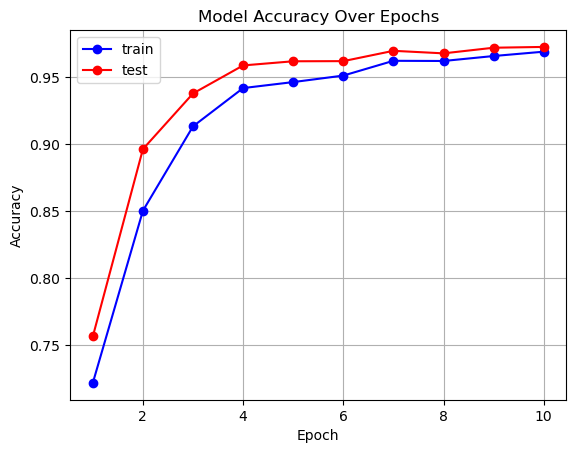

In [ ]:
plt.plot(range(1, num_epoch + 1), accuracy_list_train, marker='o', linestyle='-', color='b', label="train")
plt.plot(range(1, num_epoch + 1), accuracy_list_test, marker='o', linestyle='-', color='r', label="test")
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
l1_weights = model[0].weight.data
l1_biases = model[0].bias.data

l2_weights = model[2].weight.data
l2_biases = model[2].bias.data

l3_weights = model[4].weight.data
l3_biases = model[4].bias.data

In [ ]:
l1_weights_np = l1_weights.detach().numpy()
df = pd.DataFrame(l1_weights_np)
df.to_csv('l1_weights.csv', index=False, header=False)
print("Weights for layer one saved to 'l1_weights.csv'.")

l1_biases_np = l1_biases.detach().numpy()
df = pd.DataFrame(l1_biases_np)
df.to_csv('l1_biases.csv', index=False, header=False)
print("Biases for layer one saved to 'l1_biases.csv'.")

l2_weights_np = l2_weights.detach().numpy()
df = pd.DataFrame(l2_weights_np)
df.to_csv('l2_weights.csv', index=False, header=False)
print("Weights for layer two saved to 'l2_weights.csv'.")

l2_biases_np = l2_biases.detach().numpy()
df = pd.DataFrame(l2_biases_np)
df.to_csv('l2_biases.csv', index=False, header=False)
print("Biases for layer two saved to 'l2_biases.csv'.")

l3_weights_np = l3_weights.detach().numpy()
df = pd.DataFrame(l3_weights_np)
df.to_csv('l3_weights.csv', index=False, header=False)
print("Weights for layer three saved to 'l3_weights.csv'.")

l3_biases_np = l3_biases.detach().numpy()
df = pd.DataFrame(l3_biases_np)
df.to_csv('l3_biases.csv', index=False, header=False)
print("Biases for layer three saved to 'l3_biases.csv'.")

Weights for layer one saved to 'l1_weights.csv'.
Biases for layer one saved to 'l1_biases.csv'.
Weights for layer two saved to 'l2_weights.csv'.
Biases for layer two saved to 'l2_biases.csv'.
Weights for layer three saved to 'l3_weights.csv'.
Biases for layer three saved to 'l3_biases.csv'.
